In [2]:
import numpy as np
import h5py
from utils.DRP_uitls import *
import pyvista as pv

### Create Streamline using LagrangianParticleTracking plugin

#### Input data required by LagrangianParticleTracking plugin
* 1. [image_vel_track.vti] Velocity field with fluid density and viscosity field
* 2. [particle_seeds.vtp] Particle seeding points with particle density, diameter field
* 3. [Wall.vtm] Wall surface with boundary type tag

!! The particle tracer in Paraview is very slow, it takes 24 hours to track 100k particles in a 1000x500x500 image

One can use any other code to generate streamline into [Streamlines_particles.vtp]

#### Step1. Create cell-wise velocity field with fluid density and viscosity field

In [4]:
#Convert numpy array to paraview vti image
os.makedirs("./data/paraview_particle_tracker_data", exist_ok=True)
vtkimg = pv.read('./data/image_vel.vti')

NX,NY,NZ=np.array(vtkimg.dimensions)-1

In [14]:
vtkimg.cell_arrays['FluidDensity']=np.ones(np.prod([NX,NY,NZ]),dtype=np.float32)*1000.0 #kg/m3
vtkimg.cell_arrays['FluidViscosity']=np.ones(np.prod([NX,NY,NZ]),dtype=np.float32)*0.89 #cp
vtkimg.save("./data/paraview_particle_tracker_data/image_vel_track.vti")

#### Step2. Create Particle seeding points weighted by flux

In [15]:
#Compute velocity magn in each voxel site
Vx=vtkimg['Velocity(um/s)'][:,0].reshape([NX,NY,NZ],order="F")
Vy=vtkimg['Velocity(um/s)'][:,1].reshape([NX,NY,NZ],order="F")
Vz=vtkimg['Velocity(um/s)'][:,2].reshape([NX,NY,NZ],order="F")
Vel_magn=np.sqrt(np.power(Vx,2)+np.power(Vy,2)+np.power(Vz,2))

In [16]:
#Prepare particle tracer data

#NumPts=1000*1
#SeedingBox=[0,1*1,0,NY,0,NZ]  # Inlet layer

NumPts=1000*100
SeedingBox=[0.03*NX,0.07*NX,0.64*NY,0.79*NY,0.425*NZ,0.575*NZ]  # Cluster Box

SeedingBox=np.array(SeedingBox,dtype=np.int32)
print("Seeding Box=",SeedingBox)
Vel_seed=Vel_magn[SeedingBox[0]:SeedingBox[1],
                           SeedingBox[2]:SeedingBox[3],
                           SeedingBox[4]:SeedingBox[5]]

#Flux weighted ramdom cell selection
flux_weight=np.array(Vel_seed/np.sum(Vel_seed)).flatten(order="F")
#uniform distribution
NumActiveCell=np.sum(flux_weight>0)
flux_weight[flux_weight>0]=1.0/NumActiveCell
NumPts_cell=np.random.choice(len(flux_weight),NumPts,p=flux_weight)
cells,NumPts_cells=np.unique(NumPts_cell,return_counts=True)
#Remove zero pick cells
cells=cells[NumPts_cells>0]
NumPts_cells=NumPts_cells[NumPts_cells>0]
#Convert 1d index to 3d
cells_3d=np.unravel_index(cells,Vel_seed.shape,order="F")

NumPts_field=np.zeros_like(Vel_seed,dtype=np.int32)
NumPts_field[cells_3d]=NumPts_cells
print(np.max(NumPts_field))

Seeding Box= [ 30  70 320 395 212 287]
6


In [17]:
#Generate seeding particles based on flux weighted field
Pts=[]
cellID=0
for i,j,k in zip(*cells_3d):
    x_pts_add=SeedingBox[0]+np.random.uniform(low=i*1.0,high=(i+1)*1.0,size=NumPts_cells[cellID])
    y_pts_add=SeedingBox[2]+np.random.uniform(low=j*1.0,high=(j+1)*1.0,size=NumPts_cells[cellID])
    z_pts_add=SeedingBox[4]+np.random.uniform(low=k*1.0,high=(k+1)*1.0,size=NumPts_cells[cellID])
    for x,y,z in zip(x_pts_add,y_pts_add,z_pts_add):
        Pts+=[(x,y,z)]
    #print(x_pts_add,y_pts_add,z_pts_add)
    cellID+=1
    #if(cellID>5):break
Pts=np.array(Pts)

#Save to vtk
pts_seeding = pv.PolyData(Pts)
pts_seeding=pts_seeding.sample(vtkimg) #Velocity interpolatioin
pts_seeding['Density']=np.ones(len(Pts),dtype=np.float32)*1000.0 #kg/m3
pts_seeding['Diameter']=np.ones(len(Pts),dtype=np.float32)*0.1 #m
pts_seeding.save("./data/paraview_particle_tracker_data/particle_seeds.vtp")

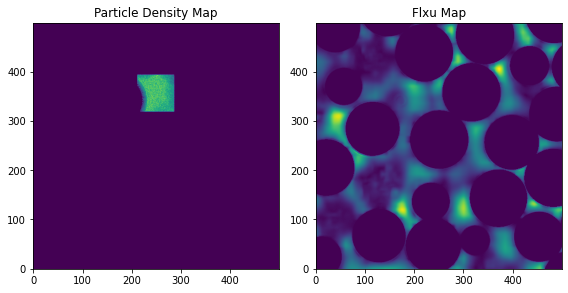

In [20]:
#Preview particle distribution
import matplotlib.pyplot as plt
from skimage import exposure

X=Pts[:,2]#Z
Y=Pts[:,1]#Y
#Extend image to whole domain
X[0],X[1]=0.0,NZ #Z
Y[0],Y[1]=0.0,NY #Y

#Particle Density map
im_data,x,y=plt.np.histogram2d(X, Y, bins=[NZ,NY])
im_data_correction=exposure.adjust_gamma(im_data,0.5)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(im_data_correction.T,origin = 'lower')
ax[1].imshow(Vel_magn[0,:,:],origin = 'lower')

ax[0].set_title('Particle Density Map')
ax[1].set_title('Flxu Map')
fig.tight_layout()
plt.show()

#### Step3. Create Wall surface with boundary type tag

In [21]:
#Prepare interaction wall
img_binary=pv.read("./data/image_binary.vti")
img_binary

UniformGrid (0x20d1709f168)
  N Cells:	250000000
  N Points:	251252001
  X Bounds:	0.000e+00, 1.000e+03
  Y Bounds:	0.000e+00, 5.000e+02
  Z Bounds:	0.000e+00, 5.000e+02
  Dimensions:	1001, 501, 501
  Spacing:	1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:	1

In [ ]:
img_binary.set_active_scalars("MetaImage")

#Get particle interaction wall from pore volume body
pore = img_binary.threshold(0.5,invert=True)
pore_surface=pore.extract_surface()
pore_surface.clear_arrays()

In [ ]:
#Split surface into bounce surface and terminate surface
centers=pore_surface.cell_centers().points

#Obtain box exterior/interior surfaces
tol=1e-6
bbox=pore_surface.bounds
bbox_select=[bbox[0]+tol, bbox[1]-tol,
             bbox[2]+tol, bbox[3]-tol,
             bbox[4]+tol, bbox[5]-tol]
inside_cells= (centers[:,0]>bbox_select[0]) & (centers[:,0]<bbox_select[1]) & \
              (centers[:,1]>bbox_select[2]) & (centers[:,1]<bbox_select[3]) & \
              (centers[:,2]>bbox_select[4]) & (centers[:,2]<bbox_select[5])
outside_cells=~inside_cells

inside_cells=np.where(inside_cells)[0]
outside_cells=np.where(outside_cells)[0]

surface_inside=pore_surface.extract_cells(inside_cells).extract_surface()
surface_outside=pore_surface.extract_cells(outside_cells).extract_surface()
surface_inside.clear_arrays()
surface_outside.clear_arrays()


```c++
typedef enum SurfaceType
  {
    SURFACE_TYPE_MODEL = 0,
    SURFACE_TYPE_TERM = 1,
    SURFACE_TYPE_BOUNCE = 2,
    SURFACE_TYPE_BREAK = 3,
    SURFACE_TYPE_PASS = 4
  } SurfaceType;
```

In [ ]:
#surface_inside.field_arrays['SurfaceType']=np.array([2],dtype=np.int32)
surface_inside.field_arrays['SurfaceType']=np.array([1],dtype=np.int32) #Terminate wall
surface_outside.field_arrays['SurfaceType']=np.array([1],dtype=np.int32) # Terminate wall
surfaces = [surface_inside,surface_outside]
surfaces = pv.MultiBlock(surfaces)
surfaces.save('./data/paraview_particle_tracker_data/Wall.vtm')

Now its ready to use Paraview particleTracking plugin to tracing streamline and save the streamline into [Streamlines_particles.vtp]

* Open Paraview
* Load [image_vel_track.vti] [particle_seeds.vtp] [Wall.vtm] 
* Load particleTracking plugin at Tools -> Manage plugins -> LagrangianParticleTracker
* Select [image_vel_track.vti] and apply LagrangianParticleTracker filter
* Filter parameters: 
```
Integrator = Runge Kutta 4/5
Cell length computation model = Current Cell Length
Num of Steps = 1500
Adaptive Step Reintergration = True
IntegrationModel.Locator = 'Static Cell Locator'
IntegrationModel.ParticleInitialVelocity = ['POINTS', 'Velocity(um/s)']
IntegrationModel.ParticleInitialIntegrationTime = ['POINTS', 'Density']
IntegrationModel.FlowVelocity = ['CELLS', 'Velocity(um/s)']
IntegrationModel.FlowDensity = ['CELLS', 'FluidDensity']
IntegrationModel.FlowDynamicViscosity = ['CELLS', 'FluidViscosity']
IntegrationModel.ParticleDiameter = ['POINTS', 'Diameter']
IntegrationModel.ParticleDensity = ['POINTS', 'Density']
```



#### Step4. Sample particles along streamlines

In [3]:
streamlines=pv.read("./data/Streamlines_particles.vtp")
streamlines

PolyData (0x2a309ed7168)
  N Cells:	100000
  N Points:	81181303
  X Bounds:	3.000e+01, 1.000e+03
  Y Bounds:	1.407e+02, 5.000e+02
  Z Bounds:	8.891e-10, 5.000e+02
  N Arrays:	5

In [4]:
img_binary=pv.read("./data/image_binary.vti")
NX,NY,NZ=np.array(img_binary.dimensions)-1

In [5]:
from utils.particle_tracker import *

#Sample particle info from streamline by given time
Times=np.linspace(0.0,150.0, 10)
Streamlines_Pts,Streamlines_Vel=Streamline2Particle(Times,streamlines)

#Some particles are stick to the wall due to integration issue 
#We need to fitler those bad particles by set up a long tracking time
print('Snapshot Time=',Times[-1])
Pts=[p[-1,:] for p in Streamlines_Pts]
Pts=np.array(Pts)

mask_stickPts =(Pts[:,0]<0.98*NX) & (Pts[:,1]<NY) & (Pts[:,2]<NZ) & \
                 (Pts[:,0]>0) & (Pts[:,1]>0) & (Pts[:,2]>0)
mask_validPts = np.invert(mask_stickPts)


Snapshot Time= 150.0


In [6]:
SimulationTime=np.max(streamlines['IntegrationTime'])
SimulationTime=20
#SimulationTime=150
OutputSteps=450

Timestep=SimulationTime/OutputSteps
Times=np.linspace(0.0,SimulationTime,OutputSteps)

print('SimulationTime=',SimulationTime)
print('Timestep=',Timestep)

Streamlines_Pts,Streamlines_Vel=Streamline2Particle(Times,streamlines)

SimulationTime= 20
Timestep= 0.044444444444444446


Snapshot Time= 4.4543429844097995


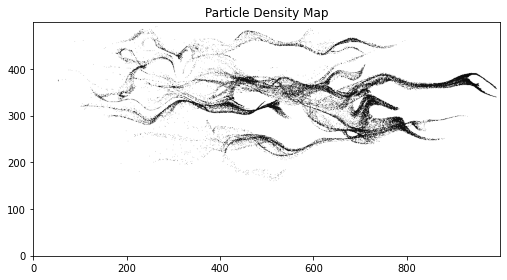

In [7]:
import matplotlib.pyplot as plt
from skimage import exposure

# Preview particle distribution by projecting to XY plane
nstep=100
print('Snapshot Time=',Times[nstep])
Pts=[p[nstep,:] for p in Streamlines_Pts]
#Pts=pv.read('particles/particles_Time9.vtp').points
Pts=np.array(Pts)

valid_mask=(Pts[:,0]<NX) & (Pts[:,1]<NY) & (Pts[:,2]<NZ) & \
           (Pts[:,0]>0) & (Pts[:,1]>0) & (Pts[:,2]>0) & (mask_validPts)
Pts=Pts[valid_mask,:]

X=Pts[:,0]#X
Y=Pts[:,1]#Y
#Extend image to whole domain
X[0],X[1]=0.0,NX #X
Y[0],Y[1]=0.0,NY #Y

#Particle Density map
im_data,x,y=plt.np.histogram2d(X, Y, bins=[NX,NY])
im_data_correction=exposure.adjust_gamma(im_data,0.02)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.imshow(im_data_correction.T,origin = 'lower',cmap='Greys')

ax.set_title('Particle Density Map')
fig.tight_layout()
plt.show()

In [8]:
#Write particle to time-seris file
import os
os.makedirs("./data/particles", exist_ok=True)

for i in tqdm(range(len(Times))):
    Pts=np.array([p[i,:] for p in Streamlines_Pts])
    Vels=np.array([v[i,:] for v in Streamlines_Vel])
    
    valid_mask=(Pts[:,0]<NX) & (Pts[:,1]<NY) & (Pts[:,2]<NZ) & \
               (Pts[:,0]>0) & (Pts[:,1]>0) & (Pts[:,2]>0) & (mask_validPts)

    pts_pv=pv.PolyData(Pts[valid_mask,:])
    pts_pv['ParticleVelocity']=Vels[valid_mask,:]
    pts_pv.save("./data/particles/particles_Time%d.vtp"%(i))

In [9]:
#Prepare projected particle image
for i in tqdm(range(len(Times))):
    Pts=[p[i,:] for p in Streamlines_Pts]
    Pts=np.array(Pts)

    valid_mask=(Pts[:,0]<NX) & (Pts[:,1]<NY) & (Pts[:,2]<NZ) & \
               (Pts[:,0]>0) & (Pts[:,1]>0) & (Pts[:,2]>0) & (mask_validPts)
    Pts=Pts[valid_mask,:]

    X=Pts[:,0]#X
    Y=Pts[:,1]#Y
    #Extend image to whole domain
    X[0],X[1]=0.0,NX #X
    Y[0],Y[1]=0.0,NY #Y

    #Particle Density map
    im_data,x,y=plt.np.histogram2d(X, Y, bins=[NX,NY])
    im_data_correction=exposure.adjust_gamma(im_data,0.02)
    #plt.imshow(im_data_correction.T,origin = 'lower')
    #plt.show()

    vtkimg = pv.UniformGrid(np.array([NX,NY,1])+1)
    vtkimg.cell_arrays['LightIntensity']=im_data_correction.flatten(order="F")
    vtkimg.save("./data/particles/proj_particles_Time%d.vti"%(i))